# 离群点检测的local outlier factor算法
## 1. 辅助函数

In [36]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
def distance_euclidean(instance1, instance2):
    '''计算两点的欧式距离'''
    differences = [0] * len(instance1)
    for i, (attr1, attr2) in enumerate(zip(instance1, instance2)):
        differences[i] = attr1 - attr2
    rmse = (sum(map(lambda x: x**2, differences)) / len(differences))**0.5
    return rmse

def k_distance(k, instance, instances, distance_function=distance_euclidean):
    """计算实例的 k-距离，并收集了 k-距离邻居的集合。
        Returns: k-距离, k-距离领域范围的点"""
    distances = {}
    for instance2 in instances:
        distance_value = distance_function(instance, instance2)
        if distance_value in distances:
            distances[distance_value].append(instance2)
        else:
            distances[distance_value] = [instance2]
    distances = sorted(distances.items())
    neighbours = []
    k_sero = 0
    k_dist = None
    for dist in distances:
        k_sero += len(dist[1])
        neighbours.extend(dist[1])
        k_dist = dist[0]
        if k_sero >= k:
            break
    return k_dist, neighbours

def reachability_distance(k, instance1, instance2, instances, distance_function=distance_euclidean):
    """计算实例1到实例2的第k可达距离, 注意这里的距离计算是有方向性的instance1->instance2
    Returns: 可达距离"""
    (k_distance_value, neighbours) = k_distance(k, instance2, instances, distance_function=distance_function)
    return max([k_distance_value, distance_function(instance1, instance2)])

def local_reachability_density(min_pts, instance, instances, **kwargs):
    """计算实例的局部可达密度
    Returns: 局部可达密度"""
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    reachability_distances_array = [0]*len(neighbours) #n.zeros(len(neighbours))
    for i, neighbour in enumerate(neighbours):
        reachability_distances_array[i] = reachability_distance(min_pts, instance, neighbour, instances, **kwargs) 
    sum_reach_dist = sum(reachability_distances_array)
    if sum_reach_dist == 0:
        return float('inf')
    return len(neighbours) / sum_reach_dist

def local_outlier_factor(min_pts, instance, instances, **kwargs):
    """计算实例的局部异常因子
    min_pts 是一个参数，用于指定在计算 LOF(局部离群因子)值时要考虑的最小实例数量。
    Returns: LOF因子"""
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    instance_lrd = local_reachability_density(min_pts, instance, instances, **kwargs)
    lrd_ratios_array = [0]* len(neighbours)
    for i, neighbour in enumerate(neighbours):
        instances_without_instance = set(instances)
        instances_without_instance.discard(neighbour)
        neighbour_lrd = local_reachability_density(min_pts, neighbour, instances_without_instance, **kwargs)
        lrd_ratios_array[i] = neighbour_lrd / instance_lrd
    return sum(lrd_ratios_array) / len(neighbours)

## 2. LOF算子

In [38]:
class LOF:
    """LOF算子"""
    def __init__(self, instances, normalize=True, distance_function=distance_euclidean):
        self.instances = instances
        self.normalize = normalize
        self.distance_function = distance_function
        if normalize:
            self.normalize_instances()

    def compute_instance_attribute_bounds(self):
        '''计算实例集合中各元素的边界，即每个元素的最大值和最小值'''
        min_values = [float("inf")] * len(self.instances[0]) 
        max_values = [float("-inf")] * len(self.instances[0]) 
        for instance in self.instances:
            min_values = tuple(map(lambda x,y: min(x,y), min_values,instance)) 
            max_values = tuple(map(lambda x,y: max(x,y), max_values,instance)) 
        self.max_attribute_values = max_values
        self.min_attribute_values = min_values
            
    def normalize_instances(self):
        """对实例集合进行归一化"""
        if not hasattr(self, "max_attribute_values"):
            self.compute_instance_attribute_bounds()
        new_instances = []
        for instance in self.instances:
            new_instances.append(self.normalize_instance(instance))
        self.instances = new_instances
        
    def normalize_instance(self, instance):
        return tuple(map(lambda value,max,min: (value-min)/(max-min) if max-min > 0 else 0, 
                         instance, self.max_attribute_values, self.min_attribute_values))
        
    def local_outlier_factor(self, min_pts, instance):
        """局部异常因子
        min_pts 是一个参数，用于指定计算 LOF 值所需考虑的最小实例数量
        Returns: local outlier factor"""
        if self.normalize:
            instance = self.normalize_instance(instance)
        return local_outlier_factor(min_pts, instance, self.instances, distance_function=self.distance_function)


## 3. 离群点计算

In [39]:
def outliers(k, instances, **kwargs):
    """获取实例集合中的异常值"""
    instances_value_backup = instances
    outliers = []
    for i, instance in enumerate(instances_value_backup):
        instances = list(instances_value_backup)
        instances.remove(instance)
        l = LOF(instances, **kwargs)
        value = l.local_outlier_factor(k, instance)
        if value > 1:
            outliers.append({"lof": value, "instance": instance, "index": i})
    outliers.sort(key=lambda o: o["lof"], reverse=True)
    return outliers

## 4. 测试用例1

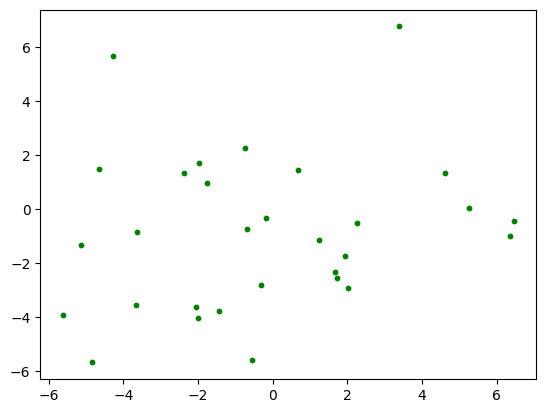

In [40]:
instances = [
 (-4.8447532242074978, -5.6869538132901658),
 (1.7265577109364076, -2.5446963280374302),
 (-1.9885982441038819, 1.705719643962865),
 (-1.999050026772494, -4.0367551415711844),
 (-2.0550860126898964, -3.6247409893236426),
 (-1.4456945632547327, -3.7669258809535102),
 (-4.6676062022635554, 1.4925324371089148),
 (-3.6526420667796877, -3.5582661345085662),
 (6.4551493172954029, -0.45434966683144573),
 (-0.56730591589443669, -5.5859532963153349),
 (-5.1400897823762239, -1.3359248994019064),
 (5.2586932439960243, 0.032431285797532586),
 (6.3610915734502838, -0.99059648246991894),
 (-0.31086913190231447, -2.8352818694180644),
 (1.2288582719783967, -1.1362795178325829),
 (-0.17986204466346614, -0.32813130288006365),
 (2.2532002509929216, -0.5142311840491649),
 (-0.75397166138399296, 2.2465141276038754),
 (1.9382517648161239, -1.7276112460593251),
 (1.6809250808549676, -2.3433636210337503),
 (0.68466572523884783, 1.4374914487477481),
 (2.0032364431791514, -2.9191062023123635),
 (-1.7565895138024741, 0.96995712544043267),
 (3.3809644295064505, 6.7497121359292684),
 (-4.2764152718650896, 5.6551328734397766),
 (-3.6347215445083019, -0.85149861984875741),
 (-5.6249411288060385, -3.9251965527768755),
 (4.6033708001912093, 1.3375110154658127),
 (-0.685421751407983, -0.73115552984211407),
 (-2.3744241805625044, 1.3443896265777866)]

for instance in instances:
    plt.scatter(instance[0], instance[1], s=10, color="green")
plt.show()


异常值的LOF及其坐标:
2.2048496921690095 (3.3809644295064505, 6.749712135929268)
1.794844084823056 (-4.27641527186509, 5.6551328734397766)
1.5012186584843135 (6.455149317295403, -0.45434966683144573)
1.4794025326219273 (6.361091573450284, -0.9905964824699189)
1.3721695654932344 (5.258693243996024, 0.032431285797532586)
1.2910019510075679 (4.603370800191209, 1.3375110154658127)
1.2027400633270513 (-4.844753224207498, -5.686953813290166)
1.1871801839835139 (-5.6249411288060385, -3.9251965527768755)
1.108985678163174 (0.6846657252388478, 1.4374914487477481)
1.057283040066788 (-4.667606202263555, 1.4925324371089148)
1.0421629593470334 (-5.140089782376224, -1.3359248994019064)
1.0280116793513516 (-0.5673059158944367, -5.585953296315335)


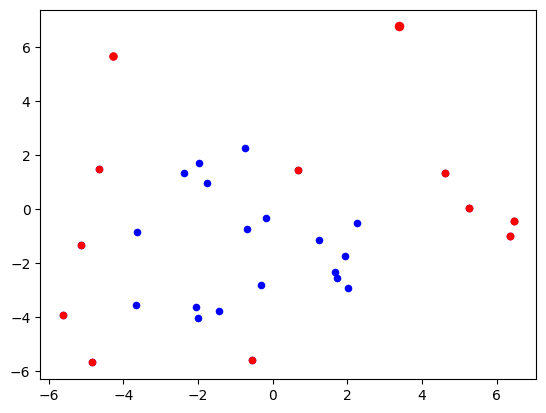

In [41]:
lof = outliers(5, instances)

print("异常值的LOF及其坐标:")
for outlier in lof:
    print(outlier["lof"],outlier["instance"])


x,y = zip(*instances)
plt.scatter(x,y, 20, color="#0000FF")

for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    color = "#FF0000" if value > 1 else "#00FF00"
    plt.scatter(instance[0], instance[1], color=color, s=(value-1)**2*10+20)

plt.show()


## 5. 测试用例2

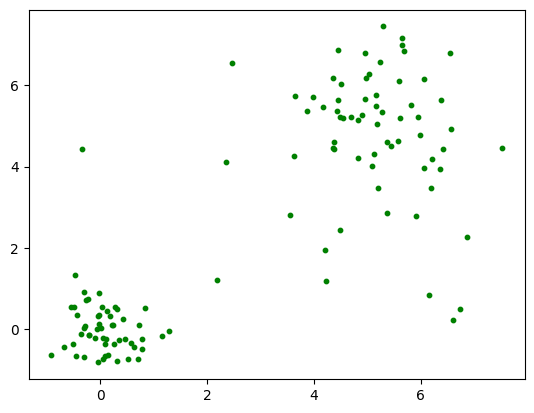

In [46]:
instance_1 = np.random.normal(0,0.5,size=(50, 2))
instance_2 = np.random.normal(5,1,size=(50, 2))
outlier_ins = np.random.uniform(-1, 7, size=(20, 2))
instances = np.concatenate((instance_1, instance_2, outlier_ins)).tolist()
instances = [(x[0],x[1]) for x in instances]
for instance in instances:
    plt.scatter(instance[0], instance[1], s=10, color="green")

plt.show()

### 5.1. k=10

异常值的LOF及其坐标:
3.9136626560664722 (2.453276369837435, 0.020642422364510082)
3.470498564196041 (1.0665166873281333, -0.9760438997612509)
3.2042533106111604 (1.2702072463897958, 1.9046583711890808)
2.986913009930839 (1.1539458475950477, 2.018273304836981)
2.655868496762973 (-0.30463769530061047, 3.2968523345483822)
2.588766423959467 (-0.839430417778189, 1.5766333246654263)
2.4858940698245 (-0.04190294544599027, 6.12421824591916)
2.357037379769207 (-0.7240421707486621, -0.7037318871882776)
2.353512908281943 (0.6915840559723572, 1.6199788174233172)
2.168603673178208 (-0.14262390928179158, 2.579298934587637)
2.148880857711623 (0.793008408072676, -0.6189077494134245)
2.05556608758358 (1.84877380718277, 6.8921219903438375)
1.965697832481546 (-0.7065343768752168, 1.019495554752166)
1.9527082013305432 (-0.503008690749851, -0.6070943063938661)
1.8148007428256911 (3.2609381316401853, 0.9397640290778373)
1.795515320985438 (-0.40911034161673626, 1.0461936378427301)
1.576591357235864 (7.06074792488198

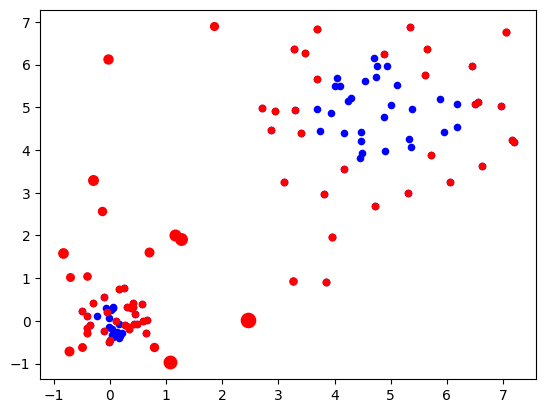

In [44]:
lof = outliers(10, instances)

print("异常值的LOF及其坐标:")
for outlier in lof:
    print(outlier["lof"],outlier["instance"])

from matplotlib import pyplot as p

x,y = zip(*instances)
plt.scatter(x,y, 20, color="#0000FF")

for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    color = "#FF0000" if value > 1 else "#00FF00"
    plt.scatter(instance[0], instance[1], color=color, s=(value-1)**2*10+20)

plt.show()

### 5.2. k=50

1.8736319008690472 (-0.30463769530061047, 3.2968523345483822)
1.7594353603327406 (3.2609381316401853, 0.9397640290778373)
1.716088829523369 (3.846198554855097, 0.8978143338879558)
1.6888587255441765 (-0.04190294544599027, 6.12421824591916)
1.5670321914750798 (-0.14262390928179158, 2.579298934587637)
1.4330795029520342 (2.453276369837435, 0.020642422364510082)
1.3845183146300173 (1.1539458475950477, 2.018273304836981)
1.3640028369702701 (1.2702072463897958, 1.9046583711890808)
1.2266772991989805 (1.84877380718277, 6.8921219903438375)
1.202163133727499 (3.9460381722423676, 1.9513091165581793)
1.1700870484035526 (-0.839430417778189, 1.5766333246654263)
1.123239909525754 (0.6915840559723572, 1.6199788174233172)
1.1226426502174924 (7.060747924881987, 6.755340842443204)
1.0391623297174966 (7.189802933217672, 4.191701714644848)
1.0318648263702062 (7.153182457511557, 4.23265243711195)
1.0188300160116524 (3.093419536925329, 3.2569078821225252)
1.016268293160918 (3.6797667929793576, 6.8314587658

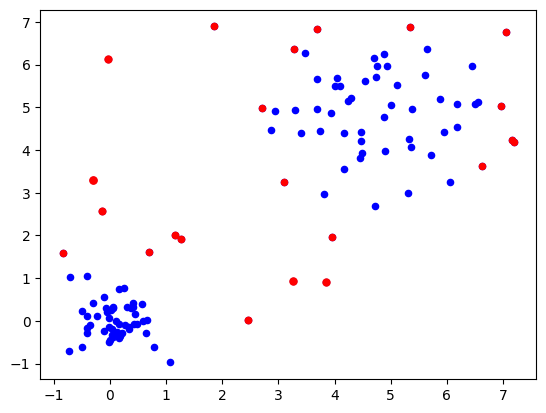

In [43]:
lof = outliers(50, instances)

print("异常值的LOF及其坐标:")
for outlier in lof:
    print(outlier["lof"],outlier["instance"])

from matplotlib import pyplot as p

x,y = zip(*instances)
plt.scatter(x,y, 20, color="#0000FF")

for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    color = "#FF0000" if value > 1 else "#00FF00"
    plt.scatter(instance[0], instance[1], color=color, s=(value-1)**2*10+20)

plt.show()